In [22]:
!pip install torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 --index-url https://download.pytorch.org/whl/cu118
!pip install timm albumentations matplotlib
!pip install numpy==1.26.4

Looking in indexes: https://download.pytorch.org/whl/cu118


In [23]:
from collections import Counter

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torchvision
from albumentations.pytorch import ToTensorV2
from termcolor import colored
from torch import nn, optim
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.patches as patches

import time

In [24]:
import os

# **VOC Dataset**

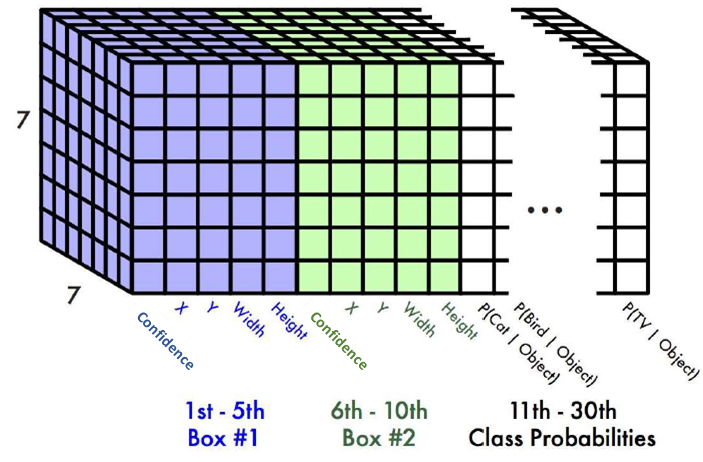
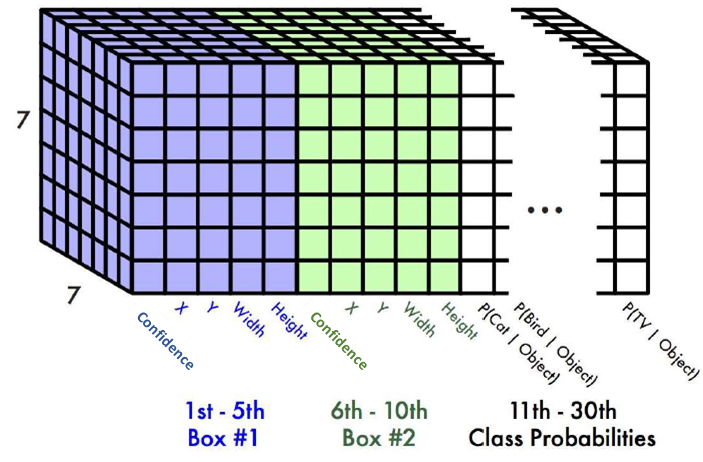
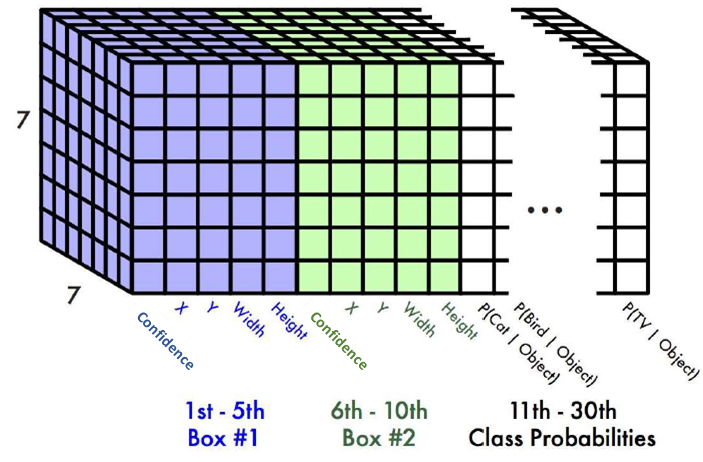
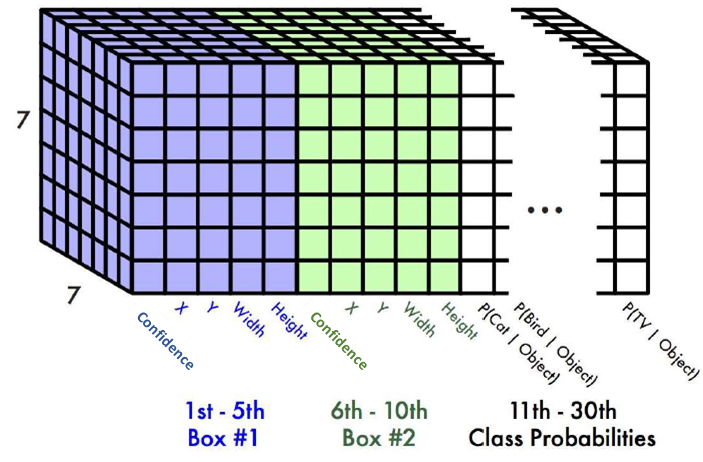

In [25]:
class CustomVOCDataset(torchvision.datasets.VOCDetection):
    def init_config_yolo(self, class_mapping, Grid_Size=7, num_bb=2, num_class = 20, transform = None):
        self.S = Grid_Size # Grid Size: SxS
        self.B = num_bb # Number of Bounding Boxes
        self.C = num_class # Number of Classes
        self.class_mapping = class_mapping # Mapping of class names to class indices
        self.transform = transform

    def __getitem__(self, idx):
        # Get Image and its Target from the VOC Dataset
        image, target = super(CustomVOCDataset, self).__getitem__(idx)
        img_width, img_height = image.size

        # Convert Annotations 2 YOLO Format
        bb = convert_to_yolo_format(target, img_width, img_height, self.class_mapping)
        boxes = bb[:, 1:]
        labels = bb[:, 0]

        # Transforms
        if self.transform:
            sample = {
                'image': np.array(image),
                'bboxes': boxes,
                'labels': labels
            }
            sample = self.transform(**sample)
            image = sample['image']
            bboxes = sample['bboxes']
            labels = sample['labels']

        # Create an empty label matrix for ground-truth
        # Height = Width = S, Depth = Number of Classes + 5 * Number of Bounding Boxes
        # Bounding Boxes = [x_center, y_center, width, height, confidence]
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        bboxes = torch.tensor(bboxes, dtype = torch.float32)
        labels = torch.tensor(labels, dtype = torch.float32)
        image = torch.as_tensor(image, dtype = torch.float32)

        # Assuming Normalized Coords and Size
        # Loop through every Bounding Boxes
        for box, class_label in zip(boxes, labels):
            x, y, width, height = box.tolist()
            class_label = int(class_label)

            # Compute grid cell (i, j) that box center falls into | Number of Boxes * Coords
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            # Compute width, height of the box relative to grid cell
            width_cell, height_cell = (
                width*self.S,
                height*self.S
            )

            # If no obj has been found before:
            if label_matrix[i, j, 20] == 0:
                # Mark that obj has been found | P = 1
                label_matrix[i, j, 20] = 1

                box_coords = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )
                label_matrix[i, j, 21:25] = box_coords
                label_matrix[i, j, class_label] = 1
                
        return image, label_matrix

In [26]:
def convert_to_yolo_format(target, img_width, img_height, class_mapping):
    """
    Convert annotation data from VOC format to YOLO format.

    Parameters:
    target (dict): Annotation data from VOCDetection dataset.
    img_width (int): Image Width
    img_height (int): Image Height
    class_mapping (dict): Mapping from class names -> IDs.

    Returns:
    torch.Tensor: Tensor of shape [N, 5] for N bounding boxes,
                  [class_id, x_center, y_center, width, height].
    """
    # Access Object Dictionary
    annotations = target["annotation"]["object"]

    # Get width and height of the image
    w = int(target["annotation"]["size"]["width"])
    h = int(target["annotation"]["size"]["height"])

    # Check if it's a list
    if not isinstance(annotations, list):
        annotations = [annotations]

    # list to store the bounding boxes.
    boxes = []

    # Loop and convert to YOLO format.
    for anno in annotations:
        xmin = int(anno["bndbox"]["xmin"]) / w
        xmax = int(anno["bndbox"]["xmax"]) / w
        ymin = int(anno["bndbox"]["ymin"]) / h
        ymax = int(anno["bndbox"]["ymax"]) / h

        # Compute Center Coords
        x_center = (xmin + xmax) / 2
        y_center = (ymin + ymax) / 2
        width = xmax - xmin
        height = ymax - ymin

        # Get the class name from the annotation and map it
        class_name = anno["name"]
        class_id = class_mapping[class_name] if class_name in class_mapping else 0

        # Append bounding box to list
        boxes.append([class_id, x_center, y_center, width, height])

    # Convert to torch tensor
    return np.array(boxes)

# **Intersection over Union (IoU)**

In [27]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculate the Intersection over Union (IoU) between boxes

    Parameters:
        boxes_preds (tensor): Outputted bounding boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Ground-truth bounding boxes (BATCH_SIZE, 4)
        box_format (str): Box format, "midpoint" or "corners"

    Returns:
        tensor: Intersection over Union scores for each example
    """

    # Check if the box format is "midpoint"
    # (x_center, y_center, width, height)
    if box_format == "midpoint":
        # Calculate coordinates of top-left (x1, y1) and bottom-right (x2, y2) points for predicted boxes
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2  # (x_center - width / 2)
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2  # (y_center - height / 2)
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2  # (x_center + width / 2)
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2  # (y_center + height / 2)

        # Calculate coordinates of top-left (x1, y1) and bottom-right (x2, y2) points for ground truth boxes
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2  # (x_center - width / 2)
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2  # (y_center - height / 2)
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2  # (x_center + width / 2)
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2  # (y_center + height / 2)

    # Check if the box format is "corners"
    if box_format == "corners":
        # Extract coordinates for predicted boxes
        box1_x1 = boxes_preds[..., 0:1]  # x1 coordinate (top-left x)
        box1_y1 = boxes_preds[..., 1:2]  # y1 coordinate (top-left y)
        box1_x2 = boxes_preds[..., 2:3]  # x2 coordinate (bottom-right x)
        box1_y2 = boxes_preds[..., 3:4]  # y2 coordinate (bottom-right y)

        # Extract coordinates for ground truth boxes
        box2_x1 = boxes_labels[..., 0:1]  # x1 coordinate (top-left x)
        box2_y1 = boxes_labels[..., 1:2]  # y1 coordinate (top-left y)
        box2_x2 = boxes_labels[..., 2:3]  # x2 coordinate (bottom-right x)
        box2_y2 = boxes_labels[..., 3:4]  # y2 coordinate (bottom-right y)

    # Calculate coordinates of the intersection rectangle:
    # We find the overlap in both x and y dimensions.
    # For the x-coordinate of the intersection, we take the maximum of the starting x (x1) 
    # and the minimum of the ending x (x2) to get the horizontal overlap.
    # Similarly for the y-coordinates.
    x1 = torch.max(box1_x1, box2_x1)  # The left boundary of the intersection (maximum of the left x-coordinates)
    y1 = torch.max(box1_y1, box2_y1)  # The top boundary of the intersection (maximum of the top y-coordinates)
    x2 = torch.min(box1_x2, box2_x2)  # The right boundary of the intersection (minimum of the right x-coordinates)
    y2 = torch.min(box1_y2, box2_y2)  # The bottom boundary of the intersection (minimum of the bottom y-coordinates)

    # Compute the area of the intersection rectangle:
    # We multiply the width and height of the intersection rectangle.
    # Use `.clamp(0)` to handle the case where the boxes don't overlap (to avoid negative values).
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)  # width * height of intersection

    # Calculate the areas of the predicted and ground truth boxes:
    # For each box, we calculate the area as width * height.
    # `box1_area` corresponds to the predicted boxes, and `box2_area` corresponds to the ground truth boxes.
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))  # Area of predicted box
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))  # Area of ground truth box

    # Calculate the Intersection over Union (IoU):
    # IoU is the ratio of the intersection area to the union area.
    # The union area is calculated as: Area of Box1 + Area of Box2 - Intersection Area
    # The epsilon (1e-6) is added to prevent division by zero if there is no overlap.
    return intersection / (box1_area + box2_area - intersection + 1e-6)  # Final IoU score

In [48]:
# Example usage of the Intersection over Union (IoU) function:

# Define two sets of bounding boxes (predictions and ground truths)
boxes_preds = torch.tensor([[5, 5, 4, 4]])  # Predicted box (x_center, y_center, width, height)
boxes_labels = torch.tensor([[6, 6, 4, 4]])  # Ground truth box (x_center, y_center, width, height)

# Calculate IoU for the given boxes
iou = intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint")

# Print the IoU score
print(f"IoU Score: {iou.item()}")

IoU Score: 0.3913043141365051


Example of Iterations:
Consider the following example where boxes_preds and boxes_labels are two batches of boxes (each containing one box):

```
boxes_preds = torch.tensor([[5, 5, 4, 4]])  # Predicted box (x_center, y_center, width, height)
boxes_labels = torch.tensor([[6, 6, 4, 4]])  # Ground truth box (x_center, y_center, width, height)
```
#
# Iteration 1:
\
Predicted Box: (x_center=5, y_center=5, width=4, height=4)
\
Ground Truth Box: (x_center=6, y_center=6, width=4, height=4)
\
Convert from Midpoint to Corners:

Predicted Box: box1_x1 = 3, box1_y1 = 3, box1_x2 = 7, box1_y2 = 7
\
Ground Truth Box: box2_x1 = 4, box2_y1 = 4, box2_x2 = 8, box2_y2 = 8
\
Intersection:

x1 = max(3, 4) = 4, y1 = max(3, 4) = 4
\
x2 = min(7, 8) = 7, y2 = min(7, 8) = 7
\
Intersection Area: (7 - 4) * (7 - 4) = 3 * 3 = 9
\
# Areas:

Predicted Box Area: (7 - 3) * (7 - 3) = 4 * 4 = 16
Ground Truth Box Area: (8 - 4) * (8 - 4) = 4 * 4 = 16
IoU Calculation:

IoU: 9 / (16 + 16 - 9) = 9 / 23 ≈ 0.3913

# **Non-Max Suppression (NMS)**

In [28]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Perform Non-Maximum Suppression on a list of bounding boxes
    
    Parameters:
        bboxes (list): List of bounding boxes [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): IoU threshold
        threshold (float): Threshold to discard predicted bbs
        box_format (str): "midpoint" or "corners"
        
    Returns:
        list: List of bounding boxes after performing NMS with a specific IoU threshold
    """

    # Check that bboxes is a list
    assert type(bboxes) == list

    # Filter if probability score > threshold
    # Only keep bounding boxes with a probability score higher than the threshold
    bboxes = [box for box in bboxes if box[1] > threshold]

    # Sort bounding boxes by descending probability score
    # The list is now sorted so that the highest confidence bounding boxes come first
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)

    # List to store bounding boxes after NMS
    bboxes_after_nms = []

    # Loop until empty
    """
    Example: bboxes = [box1, box2, box3]
    We start with a list of bounding boxes: [box1, box2, box3]
    """
    while bboxes:
        # Get the bounding box with the highest probability
        """
        At the start of the loop:
        bboxes = [box1, box2, box3]
        chosen_box = box1 (the one with the highest probability score)
        bboxes now becomes: [box2, box3]
        """
        chosen_box = bboxes.pop(0)

        # Remove bounding boxes with IoU greater than the specified threshold with the chosen box
        # If 2 boxes have high IoU => High chance they're overlapping, discard the less confident one.
        # 2 Boxes with different predictions => Not overlapping, keep both.
        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]  # Check that the class is different (this is an optional filter)
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),  # The box coordinates of the chosen box
                torch.tensor(box[2:]),         # The box coordinates of the other box
                box_format=box_format,         # "midpoint" or "corners" format
            )
            < iou_threshold  # Only keep boxes with IoU lower than the threshold
        ]
        """
        Example:
        - If bboxes = [box2, box3] and IoU threshold is 0.5:
        - box2 overlaps with box3 with an IoU > 0.5, so box3 is discarded.
        - If box2 and box3 have different predictions and the IoU is low, both will be kept.
        """

        # Add the chosen bounding box to the list after NMS
        """
        If no boxes overlap:
        After some iterations, bboxes_after_nms = [box1, box2, box3] (no boxes removed).
        
        If overlap (e.g., box2 overlaps with box3):
        - Keep highest confidence box, e.g., box2.
        - After iterations, bboxes_after_nms = [box1, box2].
        """
        bboxes_after_nms.append(chosen_box)

    # Return the list of bounding boxes after NMS
    return bboxes_after_nms

In [49]:
# Example usage of the function

# Define a list of bounding boxes [class_pred, prob_score, x1, y1, x2, y2]
# Example format: [class_pred, prob_score, x1, y1, x2, y2]
bboxes = [
    [0, 0.9, 0, 0, 1, 1],  # Class 0, high confidence, box (x1, y1, x2, y2)
    [0, 0.75, 0.1, 0.1, 1.1, 1.1],  # Class 0, medium confidence, overlapping with the previous box
    [1, 0.8, 2, 2, 3, 3],  # Class 1, medium confidence, no overlap with others
]

iou_threshold = 0.5  # Overlapping boxes with IoU > 0.5 will be suppressed
threshold = 0.7  # Only boxes with a probability score higher than 0.7 will be kept

# Perform Non-Maximum Suppression
bboxes_after_nms = non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners")

# Output the remaining bounding boxes after NMS
print(bboxes_after_nms)

[[0, 0.9, 0, 0, 1, 1], [1, 0.8, 2, 2, 3, 3]]


In [ ]:
"""
Explanation with Example Iterations
Step 1: Filter boxes by confidence score
First, we filter out bounding boxes that have a probability score less than the threshold. For example, boxes with a probability score lower than threshold=0.7 are discarded.

Box 1: [0, 0.9, 0, 0, 1, 1] (kept)
Box 2: [0, 0.75, 0.1, 0.1, 1.1, 1.1] (discarded, as 0.75 < 0.7)
Box 3: [1, 0.8, 2, 2, 3, 3] (kept)

Step 2: Sort boxes by descending probability score
Now we sort the bounding boxes based on their confidence (probability score) in descending order. This ensures that we always process the most confident box first.

Box 1: [0, 0.9, 0, 0, 1, 1]
Box 3: [1, 0.8, 2, 2, 3, 3]
Step 3: Iterative process
Now, we start the iteration process where we choose the most confident box (the first one in the list), remove it from the list, and then suppress any bounding boxes that have a high overlap (IoU) with the chosen box.

Iteration 1: Process box 1
Chosen box: Box 1 [0, 0.9, 0, 0, 1, 1]
Remaining boxes: Box 3 [1, 0.8, 2, 2, 3, 3]
IoU calculation:

Box 1: [0, 0.9, 0, 0, 1, 1] (coordinates: x1=0, y1=0, x2=1, y2=1)

Box 3: [1, 0.8, 2, 2, 3, 3] (coordinates: x1=2, y1=2, x2=3, y2=3)

Intersection: No overlap, IoU = 0.0 (IoU < 0.5, so box 3 is kept).

After this iteration, Box 1 is added to bboxes_after_nms, and Box 3 remains in the list.

Iteration 2: Process box 3
Chosen box: Box 3 [1, 0.8, 2, 2, 3, 3]
Remaining boxes: Empty, as no other boxes are left.
After this iteration, Box 3 is added to bboxes_after_nms.

Step 4: Return the final list of boxes
The function returns the final list of bounding boxes after Non-Maximum Suppression has been applied.


Final output:

[[0, 0.9, 0, 0, 1, 1], [1, 0.8, 2, 2, 3, 3]]

This output indicates that Box 2 was suppressed due to its overlap with Box 1 (IoU > 0.5), leaving Boxes 1 and 3 as the final bounding boxes after Non-Maximum Suppression.

This is how the Non-Maximum Suppression works iteratively: iterating over bounding boxes, suppressing ones that overlap too much with the most confident one
"""

# **Mean Average Precision (mAP)**

In [29]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Calculate the mean average precision (mAP)

    Parameters:
        pred_boxes (list): Containing predicted bounding boxes [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): pred_boxes but for ground-truth
        iou_threshold (float): IoU threshold
        box_format (str): "midpoint" or "corners"
        num_classes (int): Number of classes

    Returns:
        float: The mAP value across all classes with a specific IoU threshold
    """

    # Store mAP for each class
    average_precisions = []

    # Bias/Stabilizer
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Loop through all preds and targs,only add those belonging to class 'c'
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # Find the number of boxes for each training example
        # The Counter counts the number of target boxes we have
        # If image 0 has 3, and image 1 has 5,
        # we'll have:
        # amount_bboxes = {0: 3, 1: 5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # Loop through each key, val in this dictionary and convert it to
        # amount_bboxes = {0: torch.tensor([0, 0, 0]), 1: torch.tensor([0, 0, 0, 0, 0])}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # Sort by box probability, idx 2 is the probability
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # If there are no ground truth boxes for this class, it can be safely skipped
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only consider ground truth boxes with the same training index as the prediction
            ground_truth_box = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_box)
            best_iou = 0
            # Loop over all ground-truth bbs with the same training index in imae
            for idx, gt in enumerate(ground_truth_box):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx
                    
            # If predicted bounding box and ground-truth bounding box > Threshold for classification
            if best_iou > iou_threshold:
                # Only detect ground truth once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # True positive and mark this bounding box as seen
                    TP[detection_idx] = 1
                    # for Image 0: amount_bboxes = {0: torch.tensor([0, 0, 0])} 
                    # => for Image 0: amount_bboxes = {0: torch.tensor([1, 0, 0])} if 1st gt Box == Not Detected
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else: # 1 Bounding Box has highest IoU with multiple ground-truth -> False Positive
                    FP[detection_idx] = 1

            # If IOU is lower, the detection result is false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # Use torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

In [ ]:
"""
Explanation of Iterations:

Example:
Suppose we have the following predicted and ground truth boxes for class c=0:

python
Copy
Edit
pred_boxes = [
    [0, 0, 0.9, 2, 2, 4, 4],  # Prediction for image 0, class 0, high confidence
    [0, 0, 0.6, 1, 1, 3, 3],  # Prediction for image 0, class 0, moderate confidence
    [1, 0, 0.7, 5, 5, 7, 7],  # Prediction for image 1, class 0, moderate confidence
]

true_boxes = [
    [0, 0, 1.0, 2, 2, 4, 4],  # Ground truth for image 0, class 0
    [1, 0, 1.0, 6, 6, 8, 8],  # Ground truth for image 1, class 0
]
Iteration 1:
For class c=0, we start by extracting the relevant boxes from both predicted and ground truth sets:

Predicted Boxes for Class 0:

Pred Box 1: [0, 0, 0.9, 2, 2, 4, 4]
Pred Box 2: [0, 0, 0.6, 1, 1, 3, 3]
Pred Box 3: [1, 0, 0.7, 5, 5, 7, 7]
Ground Truth Boxes for Class 0:

GT Box 1: [0, 0, 1.0, 2, 2, 4, 4]
GT Box 2: [1, 0, 1.0, 6, 6, 8, 8]
We then sort the predicted boxes based on their confidence scores, highest to lowest:

python
Copy
Edit
detections = [
    [0, 0, 0.9, 2, 2, 4, 4],
    [1, 0, 0.7, 5, 5, 7, 7],
    [0, 0, 0.6, 1, 1, 3, 3]
]
We loop over each predicted box:

Checking Box 1: [0, 0, 0.9, 2, 2, 4, 4] (Highest Confidence)
This box overlaps with Ground Truth Box 1 with an IoU of 1 (perfect match).
As the IoU > threshold (0.5), this is marked as a True Positive (TP).
Checking Box 2: [1, 0, 0.7, 5, 5, 7, 7] (Moderate Confidence)
This box overlaps with Ground Truth Box 2 with an IoU of 1 (perfect match).
As the IoU > threshold (0.5), this is marked as a True Positive (TP).
Checking Box 3: [0, 0, 0.6, 1, 1, 3, 3] (Low Confidence)
No matching ground truth box for this image (IoU < 0.5).
This box is marked as a False Positive (FP).
We accumulate the True Positives (TP) and False Positives (FP) for each prediction.

For Precision and Recall, we compute the cumulative sums (TP_cumsum, FP_cumsum), which give us the running totals of TP and FP. From these, we compute the precision and recall for each detection.
Finally, the mean average precision (mAP) is calculated by averaging the average precision for all classes.

The integration of precision and recall is done using the trapezoidal rule, giving us the area under the precision-recall curve.
"""

In [30]:
# Function to get predicted and true bounding boxes from the model's output and ground truth data
def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda",
):
    all_pred_boxes = []  # List to store predicted boxes
    all_true_boxes = []  # List to store true boxes

    # Ensure the model is in evaluation mode before obtaining bounding boxes
    model.eval()
    train_idx = 0  # Index to keep track of the batch

    # Iterate through each batch in the dataset
    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)  # Move input data to the GPU
        labels = labels.to(device)  # Move labels to the GPU

        # Disable gradient calculation during inference
        with torch.no_grad():
            predictions = model(x)  # Get model predictions

        batch_size = x.shape[0]  # Number of samples in the batch
        true_bboxes = cellboxes_to_boxes(labels)  # Convert true labels to bounding boxes
        bboxes = cellboxes_to_boxes(predictions)  # Convert predicted outputs to bounding boxes

        # Process each sample in the batch
        for idx in range(batch_size):
            # Apply Non-Maximum Suppression (NMS) to filter boxes
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            # Add the filtered predicted boxes to the list
            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            # Add the true boxes if their confidence is above threshold
            for box in true_bboxes[idx]:
                if box[1] > threshold:  # If the confidence is above the threshold
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1  # Increment the batch index

    model.train()  # Switch back to training mode
    return all_pred_boxes, all_true_boxes  # Return the predicted and true bounding boxes


# Function to get predicted and true bounding boxes from the model's output during training
def get_bboxes_training(
    outputs,
    labels,
    iou_threshold=0.5,
    threshold=0.4,
    box_format="midpoint",
    device="cuda",
):
    all_pred_boxes = []  # List to store predicted boxes
    all_true_boxes = []  # List to store true boxes

    train_idx = 0  # Index to keep track of the batch

    true_bboxes = cellboxes_to_boxes(labels)  # Convert true labels to bounding boxes
    bboxes = cellboxes_to_boxes(outputs)  # Convert predicted outputs to bounding boxes

    # Process each sample in the batch
    for idx in range(outputs.shape[0]):
        # Apply Non-Maximum Suppression (NMS) to filter boxes
        nms_boxes = non_max_suppression(
            bboxes[idx],
            iou_threshold=iou_threshold,
            threshold=threshold,
            box_format=box_format,
        )

        # Add the filtered predicted boxes to the list
        for nms_box in nms_boxes:
            all_pred_boxes.append([train_idx] + nms_box)

        # Add the true boxes if their confidence is above threshold
        for box in true_bboxes[idx]:
            if box[1] > threshold:  # If the confidence is above the threshold
                all_true_boxes.append([train_idx] + box)

        train_idx += 1  # Increment the batch index

    return all_pred_boxes, all_true_boxes  # Return the predicted and true bounding boxes

# Function to convert cell-based boxes to format [x_center, y_center, width, height]
def convert_cellboxes(predictions, S=7):
    """
    
    Convert output boxes from YOLO with grid size S to image scale,
    instead of grid scale. This implementation uses loops for readability,
    as vectorized approaches can be less readable.
    
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25] # Box 1 (x, y, w, h)
    bboxes2 = predictions[..., 26:30] # Box 2 (x, y, w, h)
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1) # Selects the box with the highest confidence
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    """
    torch.arange(7) → [0, 1, 2, 3, 4, 5, 6] (Shape: [7])
    .repeat(batch_size, 7, 1) → Expands to [batch_size, 7, 7, 1] -> squeezed [batch_size, 7, 7]
    .unsqueeze(-1) → Expands to [batch_size, 7, 7, 1]

    """
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)

    """
    x_cell, y_cell = self.S * x - j, self.S * y - i
    => x, y = (x_cell + cell_indices) / S, (y_cell + cell_indices) / S
    """
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    
    w_y = 1 / S * best_boxes[..., 2:4] # w_y = [w, h]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    """
    converted_preds.shape = (batch, 7, 7, 6)
    [class,confidence,x,y,w,h]
    """
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


# Function to convert cell-based boxes to a list of boxes for each example in the batch
def cellboxes_to_boxes(out, S=7):
    # Reshape to (batch_size, 49 (Total Cells), (class, confidence, x, y, w, h))
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []
    
    # Loop through each Image in Batch
    for ex_idx in range(out.shape[0]):
        bboxes = []
        
        # Loop through every bounding box in cells
        for bbox_idx in range(S * S):
            # For x in converted_pred[Batch, Cell, Bounding Box]
            # x = [class, confidence, x, y, w, h]
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

# **YOLOv1 Architect**

In [31]:
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, split_size = 7, num_boxes = 2, num_classes = 20):

        super(Yolov1, self).__init__()
        self.split_size = split_size
        self.num_boxes = num_boxes
        self.num_classes = num_classes

        # Initialize ResNet34 backbone from timm
        # `features_only=True` returns a list of feature maps from specified stages
        # `out_indices=[4]` corresponds to the last layer's output
        self.backbone = timm.create_model(
            "resnet34",
            pretrained=True,
            features_only=True,
            out_indices=[4],
            in_chans=in_channels,
        )

        # Adaptive pooling to ensure the spatial dimensions match (S x S)
        self.pool = nn.AdaptiveAvgPool2d((self.split_size, self.split_size))

        # Fully connected layers
        self.fcs = self._create_fcs()

    @torch.autocast(device_type="cuda", dtype=torch.float16)
    def forward(self, x):

        # Extract features using ResNet34 backbone
        features = self.backbone(x)[
            0
        ]  # timm returns a list; take the first (and only) element

        # Apply adaptive pooling to match spatial dimensions
        pooled_features = self.pool(features)

        # Pass through fully connected layers
        output = self.fcs(pooled_features)

        return output

    def _create_fcs(self):
        S, B, C = self.split_size, self.num_boxes, self.num_classes

        # Calculate the input features for the first linear layer
        # ResNet34's last feature map has 512 channels
        # After pooling to (S x S), total features = 512 * S * S
        input_features = 512 * S * S

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_features, 4096),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, S * S * (C + B * 5)),
        )

# **YOLOv1 Loss**

In [32]:
class YoloLoss(nn.Module):
    """
    Calculate loss the YOLOv1 model.
    """
    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S: Grid size(7),
        B: Number of bounding boxes (2),
        C: Number of classes (in VOC dataset, it's 20).
        """
        self.S = S
        self.B = B
        self.C = C

        # These are YOLO-specific constants, representing the weight
        # for no object loss (lambda_noobj) and box coordinates loss (lambda_coord).
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):

        """
        predictions[..., :20] → Class probabilities (20 values for VOC classes).
        predictions[..., 20:21] → Confidence score for 1st bounding box.
        predictions[..., 21:25] → (x, y, w, h) for 1st bounding box.
        predictions[..., 25:26] → Confidence score for 2nd bounding box.
        predictions[..., 26:30] → (x, y, w, h) for 2nd bounding box.
        
        """
        # Reshape the predictions to the shape (BATCH_SIZE, S*S(C+B*5))
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate Intersection over Union (IoU) for the two predicted bounding boxes
        # with the target bounding box.
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Get the box with the highest IoU among the two predictions.
        # BestBox: 0 if 1st box is better, 1 if 2nd box is better
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)  # 0 if there's no object else 1

        # ========================= #
        #     BOUNDING BOX LOSS     #
        # ========================= #

        # Set the boxes with no objects to zero. Choose one of the two predictions
        # based on the bestbox index calculated earlier.
        # box_predictions Shape = (batch_size, S, S, 4) [4: (x, y, w, h)]
        # Only applies to cell with an object => multiplying by exists_box (0 if it doesnt)
        box_predictions = exists_box * (
            bestbox * predictions[..., 26:30] + (1 - bestbox) * predictions[..., 21:25]
        )

        box_targets = exists_box * target[..., 21:25]

        # Take the square root of width and height to ensure positive values.
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ======================== #
        #   FOR OBJECTNESS LOSS    #
        # ======================== #

        # pred_box represents the confidence score of the box with the highest IoU.
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #
        
        """
        If a grid cell should not contain an object (exists_box = 0),
        we penalize any nonzero confidence in that cell.
        The no-object loss is just the sum of the squared confidence scores 
        for both predicted boxes in these empty cells.
        """
        
        # Exists => No Object Loss = 0 <=> No Loss
        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #
        """
        YOLOv1 uses MSE, don't question me
        """
        class_loss = self.mse(
            torch.flatten(
                exists_box * predictions[..., :20], # Take the 20 Probabilities for 20 Classes
                end_dim=-2,
            ),
            torch.flatten(
                exists_box * target[..., :20],
                end_dim=-2,
            ),
        )

        # Calculate the final loss by combining the above components.
        loss = (
            self.lambda_coord * box_loss  # First term
            + object_loss  # Second term
            + self.lambda_noobj * no_object_loss  # Third term
            + class_loss  # Fourth term
        )

        return loss

# **Config**

In [33]:
# Miscs
lr = 2e-5

# Data Loaders Config
BATCH_SIZE = 64
num_epochs = 10
NUM_WORKERS = 4
PIN_MEMORY = True
LOAD_MODEL = False

# Device
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

LOAD_MODEL_FILE = "homemade_yolov1.pth.tar"

# Image Fixed Size
WIDTH = 448
HEIGHT = 448

In [34]:
def initialize_model():
    """Initialize the model, optimizer, and loss function."""
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = YoloLoss()
    return model, optimizer, loss_fn

# **Augmentations**

In [35]:
def get_train_transforms():
    return A.Compose(
        [
            A.OneOf(
                [
                    A.HueSaturationValue(
                        hue_shift_limit=0.2,
                        sat_shift_limit=0.2,
                        val_shift_limit=0.2,
                        p=0.9,
                    ),
                    A.RandomBrightnessContrast(
                        brightness_limit=0.2, contrast_limit=0.2, p=0.9
                    ),
                ],
                p=0.9,
            ),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.2),
            A.VerticalFlip(p=0.2),
            A.Resize(height=HEIGHT, width=WIDTH, p=1),
            ToTensorV2(p=1.0),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="yolo", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )


def get_val_transforms():  # Keep validation augmentations light
    return A.Compose(
        [A.Resize(height=HEIGHT, width=WIDTH, p=1.0), ToTensorV2(p=1.0)],
        p=1.0,
        bbox_params=A.BboxParams(
            format="yolo", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )

# **Mapping**

In [36]:
class_mapping = {
    "aeroplane": 0,
    "bicycle": 1,
    "bird": 2,
    "boat": 3,
    "bottle": 4,
    "bus": 5,
    "car": 6,
    "cat": 7,
    "chair": 8,
    "cow": 9,
    "diningtable": 10,
    "dog": 11,
    "horse": 12,
    "motorbike": 13,
    "person": 14,
    "pottedplant": 15,
    "sheep": 16,
    "sofa": 17,
    "train": 18,
    "tvmonitor": 19,
}

# **Miscs**

In [37]:
from torch.utils.data import ConcatDataset
import time

def prepare_data():
    """Prepare datasets and create data loaders for training, validation and testing."""
    # Prepare training dataset
    train_dataset = CustomVOCDataset(
        root="./data",
        year="2012",
        image_set="train",
        download=True,
    )
    train_dataset.init_config_yolo(
        class_mapping=class_mapping, transform=get_train_transforms()
    )

    # Prepare validation dataset
    val_dataset = CustomVOCDataset(
        root="./data",
        year="2012",
        image_set="val",
        download=False,
    )
    val_dataset.init_config_yolo(
        class_mapping=class_mapping, transform=get_val_transforms()
    )

    # Combine datasets
    combined_dataset = ConcatDataset([train_dataset, val_dataset])
    total_size = len(combined_dataset)

    # Calculate split sizes (7:2:1 ratio)
    train_size = int(0.7 * total_size)
    val_size = int(0.2 * total_size)
    test_size = total_size - train_size - val_size

    # Generate indices for splits
    indices = list(range(total_size))
    np.random.shuffle(indices)

    train_indices = indices[:train_size]
    val_indices = indices[train_size : train_size + val_size]
    test_indices = indices[train_size + val_size :]

    # Create samplers
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    # Create data loaders
    train_loader = DataLoader(
        dataset=combined_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        sampler=train_sampler,
        drop_last=False,
    )

    val_loader = DataLoader(
        dataset=combined_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        sampler=val_sampler,
        drop_last=False,
    )

    test_loader = DataLoader(
        dataset=combined_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        sampler=test_sampler,
        drop_last=False,
    )

    return (
        train_loader,
        val_loader,
        test_loader,
    )

# **Train**

In [38]:
def eval_epoch(model, val_loader, device, num_classes = 20):
    model.eval()
    mean_loss = []
    mean_mAP = []

    with torch.no_grad():
        for idx, (images, targets) in enumerate (val_loader):
            images = images.to(device)
            targets = targets.to(device)
            
            outputs = model(images)
            loss = loss_fn(outputs, targets)

            pred_boxes, gt_boxes = get_bboxes_training(outputs, targets,
                                                       iou_threshold = .5,
                                                       threshold = .4)
            mAP = mean_average_precision(pred_boxes, gt_boxes,
                                        iou_threshold = .5,
                                        box_format = "midpoint")
            mean_loss.append(loss.item())
            mean_mAP.append(mAP.item())
    avg_loss = sum(mean_loss)/len(mean_loss)
    avg_mAP = sum(mean_mAP)/len(mean_mAP)
    return avg_loss, avg_mAP

In [39]:
def train_epoch(model, optim, train_loader, device, epoch = 0, num_classes=20, log_interval = 40):
    model.train()
    mean_loss = []
    mean_mAP = []
    start_time = time.time()

    for idx, (images, targets) in enumerate(train_loader):
        
        images = images.to(device)
        targets = targets.to(device)
            
        outputs = model(images)
        loss = loss_fn(outputs, targets)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        pred_boxes, gt_boxes = get_bboxes_training(outputs, targets,
                                                    iou_threshold = .5,
                                                    threshold = .4)
        mAP = mean_average_precision(pred_boxes, gt_boxes,
                                    iou_threshold = .5,
                                    box_format = "midpoint")
        mean_loss.append(loss.item())
        mean_mAP.append(mAP.item())
        if idx % log_interval == 0 and idx > 0:
            print(
                f"Epoch {epoch} | {idx}/{len(train_loader)} Batches | Loss: {loss.item():3.10f} | mAP: {mAP.item():3.10f}"
            )
    avg_loss = sum(mean_loss)/len(mean_loss)
    avg_mAP = sum(mean_mAP)/len(mean_mAP)
    return avg_loss, avg_mAP

In [40]:
def plot_image_with_labels(
    image, ground_truth_boxes, predicted_boxes, class_mapping, ax=None
):
    """Draw both ground truth and predicted bounding boxes on an image, with labels and confidence score."""

    # Inverting the class mapping for easy access of class names based on indices
    inverted_class_mapping = {v: k for k, v in class_mapping.items()}

    # Convert the image to a numpy array and get its dimensions
    im = np.array(image)
    height, width, _ = im.shape

    ax.axis("off")
    ax.imshow(im)

    # Plot each ground truth box in green with adjustments for visibility
    for box in ground_truth_boxes:
        # Extract label index and bounding box coordinates
        label_index, box = box[0], box[2:]
        # Calculate upper left coordinates
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        # Create a rectangle patch with increased line width and visible color
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=5,  # Increased line width
            edgecolor="green",
            facecolor="none",
        )
        # Add the rectangle to the plot
        ax.add_patch(rect)
        # Retrieve the class name and add it as text to the plot
        class_name = inverted_class_mapping.get(label_index, "Unknown")
        ax.text(
            upper_left_x * width,
            upper_left_y * height,
            class_name,
            color="white",
            fontsize=14,  # Increased font size
            bbox=dict(facecolor="green", alpha=0.6),  # Increased alpha for better contrast
        )

    # Plot each predicted box in red with confidence score and better visibility
    for box in predicted_boxes:
        # Extract the class, confidence, and box coordinates
        label_index, confidence_score, box = box[0], box[1], box[2:]
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=5,  # Increased line width for better visibility
            edgecolor="red",
            facecolor="none",
        )
        ax.add_patch(rect)
        # Retrieve the class name
        class_name = inverted_class_mapping.get(label_index, "Unknown")
        # Display class name with confidence score in a more visible manner
        ax.text(
            upper_left_x * width,
            upper_left_y * height,
            f"{class_name} ({confidence_score:.2f})",  # Add confidence score to the label
            color="white",
            fontsize=14,  # Increased font size
            bbox=dict(facecolor="red", alpha=0.6),  # Increased alpha for better contrast
        )

    return ax

In [41]:
def train(model, model_name, save_model, optim, train_loader, val_loader, num_epochs, device):
    train_losses, train_mAPs, eval_losses, eval_mAPs = [], [], [], []
    best_mAP = -1
    times = []
    
    for epoch in range(1, num_epochs + 1):
        print(f"Starting Epoch {epoch}....\n")
        epoch_start_time = time.time()
        
        train_loss, train_mAP = train_epoch(model, optim, train_loader, device, epoch)
        train_losses.append(train_loss)
        train_mAPs.append(train_loss)
        
        val_loss, eval_mAP = eval_epoch(model, val_loader, device)
        eval_losses.append(val_loss)
        eval_mAPs.append(eval_mAP)
        
        if best_mAP < eval_mAP:
            torch.save(model.state_dict(), save_model + f"/{model_name}.pt")
            inputs_t, labels_t = next(iter(val_loader))
            inputs_t = inputs_t.to(device)
            labels_t = labels_t.to(device)
            out = model(inputs_t)
            pred_bboxes = cellboxes_to_boxes(out)
            gt_bboxes = cellboxes_to_boxes(labels_t)
            fig, axes = plt.subplots(2, 4, figsize = (12, 12))
            axes = axes.flatten()
            for idx in range (8):
                pred_box = non_max_suppression(
                    pred_bboxes[idx], iou_threshold = .5, threshold = .4, box_format = "midpoint"
                )
                gt_box = non_max_suppression(
                    gt_bboxes[idx], iou_threshold = 0.5, threshold = .4, box_format = 'midpoint'
                )
                image = inputs_t[idx].permute(1, 2, 0).to('cpu')/255
                ax_image = plot_image_with_labels(
                    image, gt_box, pred_box, class_mapping, ax = axes[idx]
                )
            plt.tight_layout
            plt.show()
            print(" ")
            # generate_samples_prediction(model, inputs_t, labels_t, device, class_mapping)
            print(" ")
            best_mAP = eval_mAP
        
        times.append(time.time() - epoch_start_time)
        
        print(
            f"| End of Epoch {epoch} | Time Taken: {times[-1]:3.10f}s | Train mAP: {train_mAP:3.10f} | Train Loss: {train_loss:3.10f} | "
            f"Eval Loss: {val_loss:3.10f} | Eval mAP: {eval_mAP:3.10f}"
        )
        print(f"Ending Epoch {epoch}...\n")
        print("-" * 59)
    
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
    model.eval()
    metrics = {
        'Train mAP': train_mAPs,
        'Train Loss': train_losses,
        'Eval Loss': eval_losses,
        'Eval mAP': eval_mAPs,
        'Time': times
    }
    return model, metrics

In [42]:
train_loader, val_loader, test_loader = prepare_data()

100%|██████████| 1999639040/1999639040 [01:21<00:00, 24583141.62it/s]


Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [43]:
model, optim, loss_fn = initialize_model()

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [44]:
model_name = 'HomemadeYOLOv1'
save_model = './HomemadeYOLOv1'
os.makedirs(save_model, exist_ok = True)

Starting Epoch 1....

Epoch 1 | 40/127 Batches | Loss: 706.2023925781 | mAP: 0.0035029587
Epoch 1 | 80/127 Batches | Loss: 849.1496582031 | mAP: 0.0453969985
Epoch 1 | 120/127 Batches | Loss: 583.4506225586 | mAP: 0.0070350477


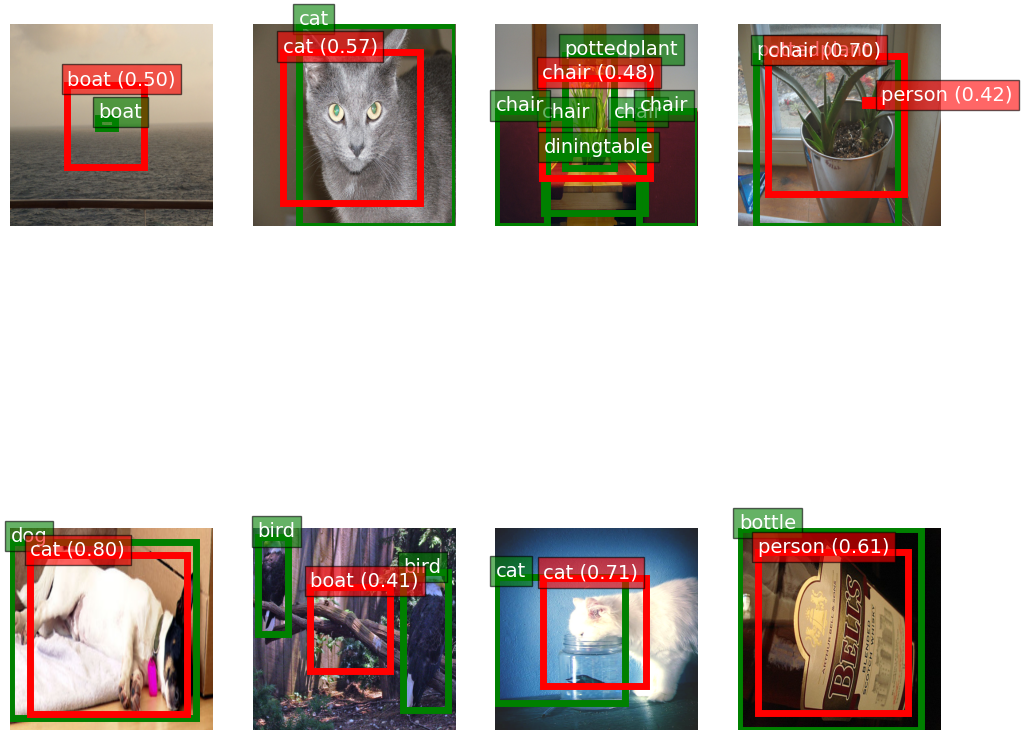

 
 
| End of Epoch 1 | Time Taken: 124.8866033554s | Train mAP: 0.0236886519 | Train Loss: 1012.8896384652 | Eval Loss: 699.8434212659 | Eval mAP: 0.0448684531
Ending Epoch 1...

-----------------------------------------------------------
Starting Epoch 2....

Epoch 2 | 40/127 Batches | Loss: 684.5609130859 | mAP: 0.0892738253
Epoch 2 | 80/127 Batches | Loss: 580.0181274414 | mAP: 0.1200611144
Epoch 2 | 120/127 Batches | Loss: 562.1638183594 | mAP: 0.0973463207


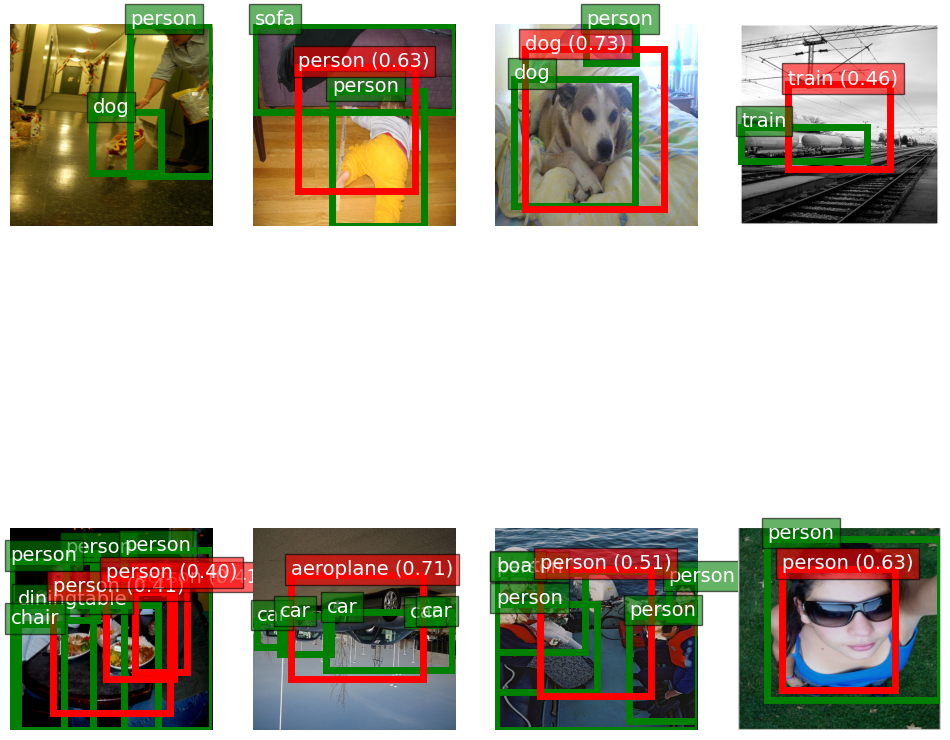

 
 
| End of Epoch 2 | Time Taken: 127.4980318546s | Train mAP: 0.0892915010 | Train Loss: 648.8734211358 | Eval Loss: 644.4345482491 | Eval mAP: 0.0838875390
Ending Epoch 2...

-----------------------------------------------------------
Starting Epoch 3....

Epoch 3 | 40/127 Batches | Loss: 616.4561767578 | mAP: 0.1595996916
Epoch 3 | 80/127 Batches | Loss: 495.2243652344 | mAP: 0.2324617803
Epoch 3 | 120/127 Batches | Loss: 463.9912109375 | mAP: 0.2105031759


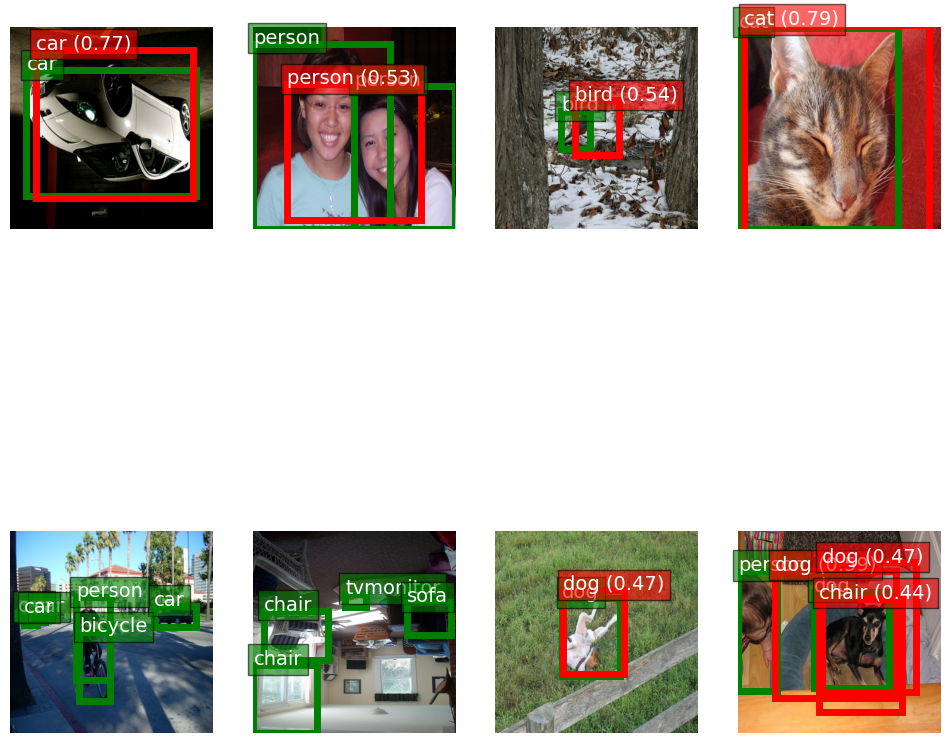

 
 
| End of Epoch 3 | Time Taken: 132.1712417603s | Train mAP: 0.1524009448 | Train Loss: 542.9083228524 | Eval Loss: 601.0576568294 | Eval mAP: 0.1420662679
Ending Epoch 3...

-----------------------------------------------------------
Starting Epoch 4....

Epoch 4 | 40/127 Batches | Loss: 489.4931640625 | mAP: 0.2004191428
Epoch 4 | 80/127 Batches | Loss: 431.3771362305 | mAP: 0.2569994032
Epoch 4 | 120/127 Batches | Loss: 425.8247070312 | mAP: 0.1559002846


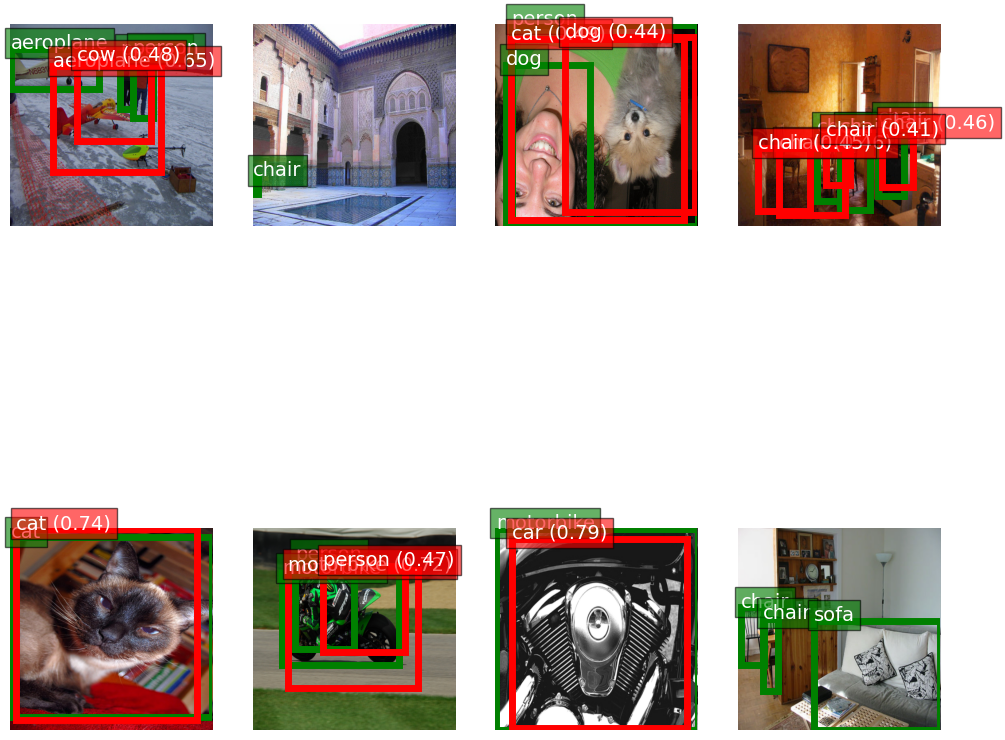

 
 
| End of Epoch 4 | Time Taken: 132.5408761501s | Train mAP: 0.2085426239 | Train Loss: 463.1873188169 | Eval Loss: 580.3013784048 | Eval mAP: 0.1678063424
Ending Epoch 4...

-----------------------------------------------------------
Starting Epoch 5....

Epoch 5 | 40/127 Batches | Loss: 381.9444885254 | mAP: 0.2437085360
Epoch 5 | 80/127 Batches | Loss: 370.1315917969 | mAP: 0.3432797790
Epoch 5 | 120/127 Batches | Loss: 402.4791870117 | mAP: 0.2259200215


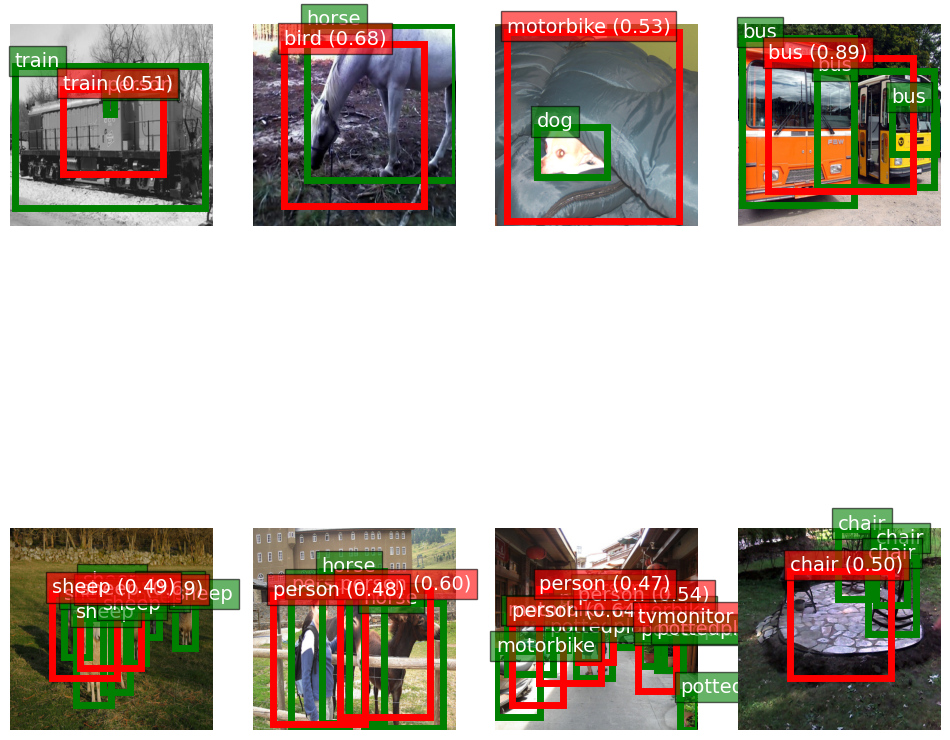

 
 
| End of Epoch 5 | Time Taken: 135.4517042637s | Train mAP: 0.2725763289 | Train Loss: 396.5028047336 | Eval Loss: 568.3947829169 | Eval mAP: 0.1861423520
Ending Epoch 5...

-----------------------------------------------------------
Starting Epoch 6....

Epoch 6 | 40/127 Batches | Loss: 312.1374816895 | mAP: 0.4334984720
Epoch 6 | 80/127 Batches | Loss: 351.7392578125 | mAP: 0.3049299419
Epoch 6 | 120/127 Batches | Loss: 323.1879882812 | mAP: 0.2910960019


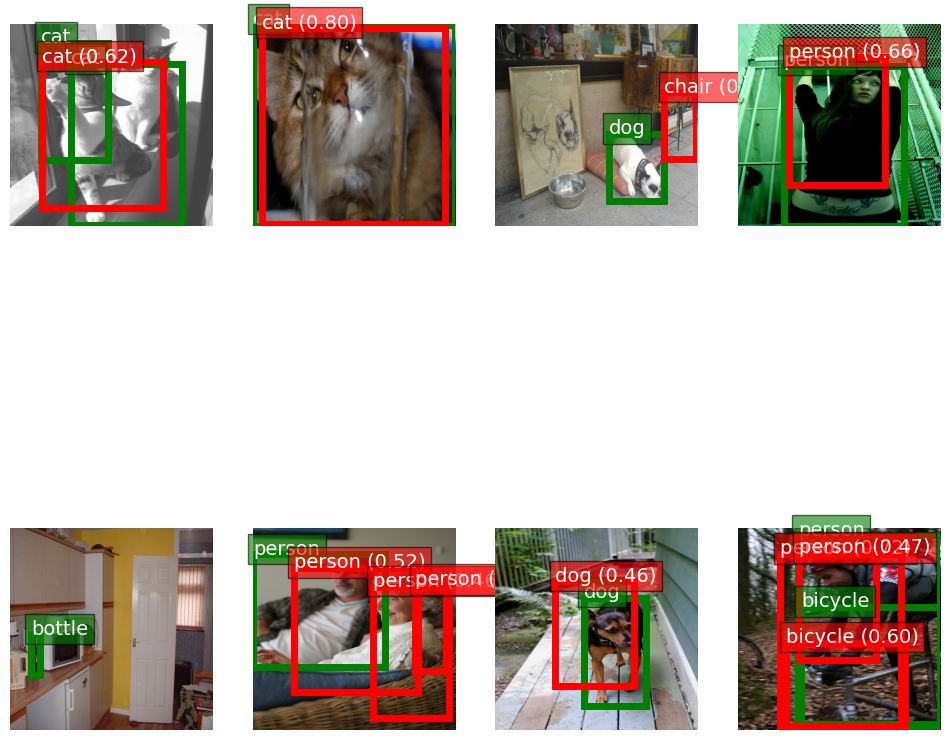

 
 
| End of Epoch 6 | Time Taken: 134.8804836273s | Train mAP: 0.3511931889 | Train Loss: 338.8120840478 | Eval Loss: 543.8139126752 | Eval mAP: 0.2047458488
Ending Epoch 6...

-----------------------------------------------------------
Starting Epoch 7....

Epoch 7 | 40/127 Batches | Loss: 302.4362792969 | mAP: 0.4476463795
Epoch 7 | 80/127 Batches | Loss: 292.2052917480 | mAP: 0.5154960155
Epoch 7 | 120/127 Batches | Loss: 321.3005065918 | mAP: 0.3854711354
| End of Epoch 7 | Time Taken: 130.7402637005s | Train mAP: 0.4410614188 | Train Loss: 290.6783440657 | Eval Loss: 532.9528301342 | Eval mAP: 0.2016856628
Ending Epoch 7...

-----------------------------------------------------------
Starting Epoch 8....

Epoch 8 | 40/127 Batches | Loss: 220.7163543701 | mAP: 0.4405331016
Epoch 8 | 80/127 Batches | Loss: 217.0861663818 | mAP: 0.5819522738
Epoch 8 | 120/127 Batches | Loss: 277.8321228027 | mAP: 0.5321347117


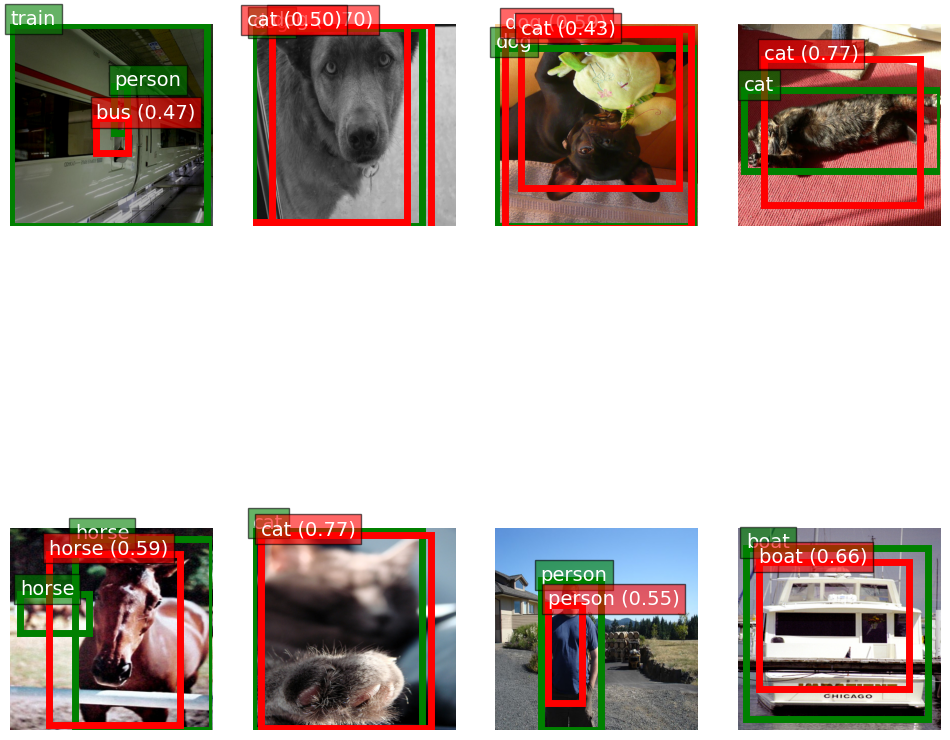

 
 
| End of Epoch 8 | Time Taken: 138.5678975582s | Train mAP: 0.5202306807 | Train Loss: 258.3560858298 | Eval Loss: 524.9018592834 | Eval mAP: 0.2278553078
Ending Epoch 8...

-----------------------------------------------------------
Starting Epoch 9....

Epoch 9 | 40/127 Batches | Loss: 249.0994567871 | mAP: 0.5893845558
Epoch 9 | 80/127 Batches | Loss: 231.8755950928 | mAP: 0.5318156481
Epoch 9 | 120/127 Batches | Loss: 226.6574707031 | mAP: 0.5630463362
| End of Epoch 9 | Time Taken: 134.1560158730s | Train mAP: 0.5923898105 | Train Loss: 225.9507154630 | Eval Loss: 517.5189378068 | Eval mAP: 0.2157656716
Ending Epoch 9...

-----------------------------------------------------------
Starting Epoch 10....

Epoch 10 | 40/127 Batches | Loss: 223.2715148926 | mAP: 0.6514344215
Epoch 10 | 80/127 Batches | Loss: 180.5186462402 | mAP: 0.6351628304
Epoch 10 | 120/127 Batches | Loss: 181.5593566895 | mAP: 0.7432894111


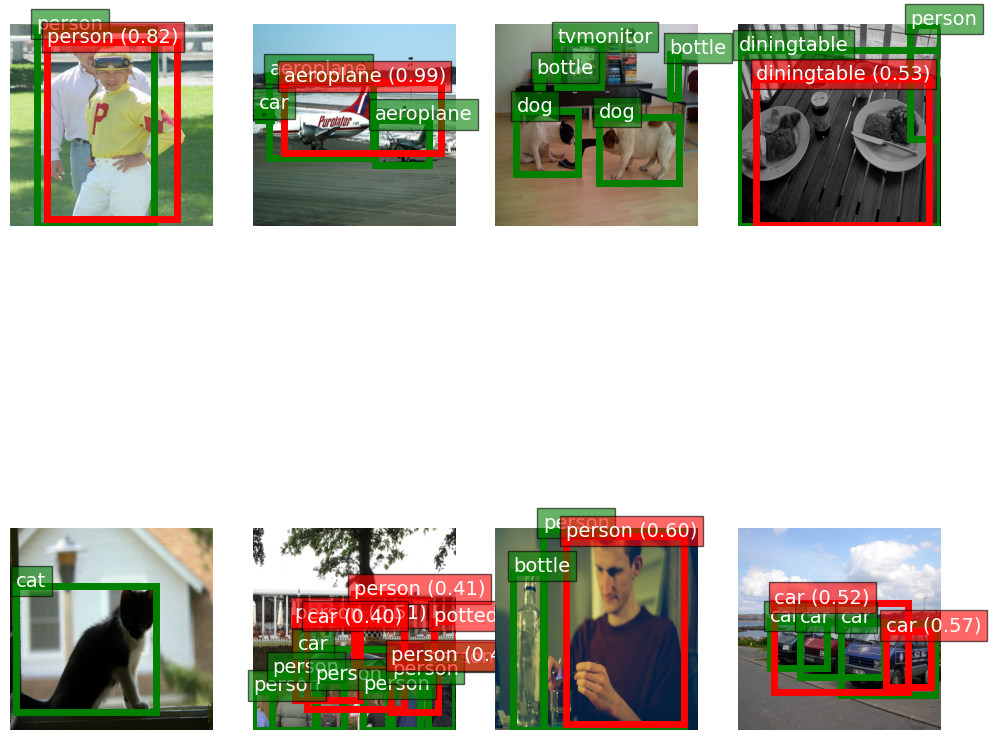

 
 
| End of Epoch 10 | Time Taken: 140.0157406330s | Train mAP: 0.6435992727 | Train Loss: 202.6321675458 | Eval Loss: 519.8478612127 | Eval mAP: 0.2305442284
Ending Epoch 10...

-----------------------------------------------------------


(Yolov1(
   (backbone): FeatureListNet(
     (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (act1): ReLU(inplace=True)
     (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     (layer1): Sequential(
       (0): BasicBlock(
         (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (drop_block): Identity()
         (act1): ReLU(inplace=True)
         (aa): Identity()
         (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (act2): ReLU(inplace=True)
       )
       (1): BasicBlock(
         (conv1): Conv2d(64, 64, kernel_size=(3, 3), s

In [45]:
train(model, model_name, save_model, optim, train_loader, val_loader, num_epochs, device)

IndexError: index 8 is out of bounds for axis 0 with size 8

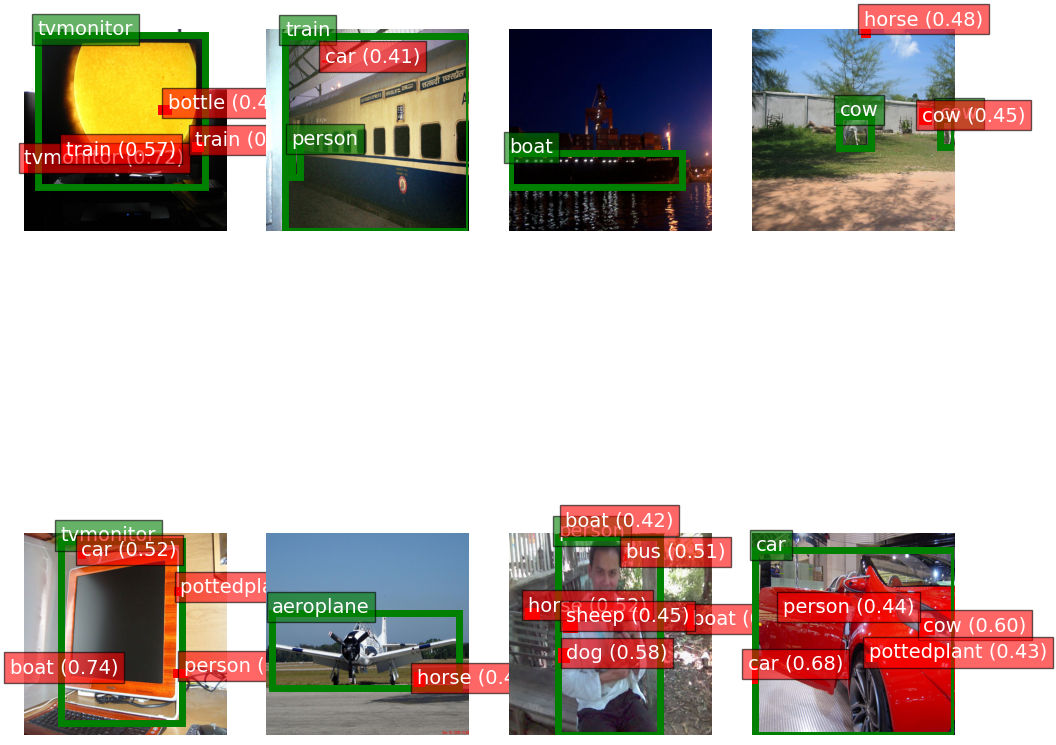

In [46]:
LOAD_MODEL = False
def test():
    # Create a YOLO model object with specific hyperparameters.
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(device)

    # Skip model loading if no pre-trained weights are available
    if LOAD_MODEL:
        model.load_state_dict(torch.load(LOAD_MODEL_FILE)["state_dict"])

    # Prepare the validation dataset and DataLoader for model evaluation
    val_dataset = CustomVOCDataset(root="./data", image_set="val", download=False)
    val_dataset.init_config_yolo(
        class_mapping=class_mapping, transform=get_val_transforms()
    )
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=False,
        drop_last=False,
    )

    model.eval()
    # Iterate over the validation dataset and process each batch
    for x, y in val_loader:
        x = x.to(device)
        out = model(x)

        # Convert model output to bounding boxes and apply non-max suppression
        pred_bboxes = cellboxes_to_boxes(out)
        gt_bboxes = cellboxes_to_boxes(y)

        fig, axes = plt.subplots(2, 4, figsize=(12, 12))  # 2 rows, 5 columns for displaying 10 images
        axes = axes.flatten()

        # Plot the first 10 images with their ground truth and predicted bounding boxes
        for idx in range(10):
            pred_box = non_max_suppression(
                pred_bboxes[idx],
                iou_threshold=0.5,
                threshold=0.4,
                box_format="midpoint",
            )
            gt_box = non_max_suppression(
                gt_bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint"
            )

            image = x[idx].permute(1, 2, 0).to("cpu") / 255  # Normalize for displaying
            ax_image = plot_image_with_labels(
                image, gt_box, pred_box, class_mapping, ax=axes[idx]
            )

        plt.tight_layout()
        plt.show()

        break  # Stop after processing the first batch

test()